In [1]:
%matplotlib inline
import numpy as np
import sys
import math
from sklearn.preprocessing import Imputer
import os.path
import h5py
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import ROOT as R
from ROOT import gROOT, gDirectory, TFile, TEventList, TCut, TH1F, TH2F, TCanvas, kRed, TLegend
from root_numpy import tree2array, root2array

In [3]:
import uproot
import pandas as pd

In [4]:
bkg_open = uproot.open("/home/michael/Desktop/OpenData/SM_Backgrounds/mc15_13TeV.364102.Sh_221_NNPDF30NNLO_Zmumu_MAXHTPTV0_70_BFilter.2lep_raw.root")["mini"]
sig_open = uproot.open("/home/michael/Desktop/OpenData/SM_Backgrounds/mc15_13TeV.410000.PwPyEG_P2012_ttbar_hdamp172p5_nonallhad.2lep_raw.root")["mini"]

In [5]:
bkg = bkg_open.pandas.df(["lep_pt","lep_phi","lep_eta","met_et"],flatten =False) 
sig = sig_open.pandas.df(["lep_pt","lep_phi","lep_eta","met_et"],flatten =False)
print bkg.shape
print sig.shape

(2545299, 4)
(2910544, 4)


In [6]:
bkg['label'] = np.zeros(len(bkg.met_et))
sig['label'] = np.ones(len(sig.met_et))

In [7]:
mix = pd.concat([bkg,sig],ignore_index=True)

In [8]:
# Define variables that are not already present in the ntuples
def dilep(lep_pts,lep_etas,lep_phis):
    cosh = math.cosh(lep_etas[0]-lep_etas[1])
    cos = math.cos(lep_etas[0]-lep_etas[1])
    mll = 2*lep_pts[0]*lep_pts[1]*(cosh-cos)
    return math.sqrt(mll)

In [9]:
# Add the variables
mix['mll'] = np.vectorize(dilep)(mix.lep_pt,mix.lep_eta,mix.lep_phi)

In [10]:
# Pre-selection cuts
def cut_lep_pt(lep_pt):
    return (lep_pt[0]<25000)|(lep_pt[1]<25000)
fail_pt = mix[np.vectorize(cut_lep_pt)(mix.lep_pt)].index

In [11]:
mix.drop(fail_pt, inplace=True) #define new array
mix.shape

(3836073, 6)

In [ ]:
def cut_mll(mll):
    return (mll<40000)
fail_mll = mix[np.vectorize(cut_mll)(mix.mll)].index

In [ ]:
mix.drop(fail_mll, inplace=True)
mix.shape

In [12]:
X = mix[['met_et','mll']]
Y = mix['label']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

In [ ]:
X_train.head()

In [15]:
X_train_new = X_train.reset_index()
X_train_clean = X_train_new.drop(columns=['index'])
Y_train_new = Y_train.reset_index()
Y_train_clean = Y_train_new.drop(columns=['index'])
X_test_new = X_test.reset_index()
X_test_clean = X_test_new.drop(columns=['index'])

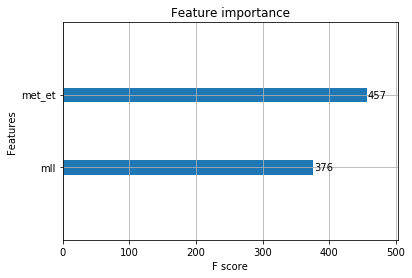

In [16]:
#BDT block
import xgboost as xgb

xgbclassifier = xgb.XGBClassifier(
    max_depth=3, 
    n_estimators=120,
    learning_rate=0.1,
    n_jobs=4,
    #scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic')
    #missing=-999.0) 
xgbclassifier.fit(X_train_clean, Y_train_clean) 

# Plot variable importance for BDT
xgb.plot_importance(xgbclassifier)
plt.show()

#Give predicted Y values for BDT
Y_pred = xgbclassifier.predict(X_test_clean)
Y_pred_proba = xgbclassifier.predict_proba(X_test_clean)

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=4)
logreg.fit(X_train_clean, Y_train_clean)
Y_pred = logreg.predict(X_test_clean)
Y_pred_proba = logreg.predict_proba(X_test_clean)

In [ ]:
#Support vector machine
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_clean, Y_train_clean)
Y_pred = svc.predict(X_test_clean)
Y_pred_proba = svc.predict_proba(X_test_clean)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=20)
RF.fit(X_train_clean, Y_train_clean)
Y_pred = RF.predict(X_test_clean)
Y_pred_proba = RF.predict_proba(X_test_clean)

In [ ]:
Y_pred.shape

In [17]:
Y_test_new = Y_test.reset_index()
Y_test_new.head()

,index,label
0,2497830,0.0
1,632008,0.0
2,5433771,1.0
3,485090,0.0
4,573429,0.0


In [18]:
Y_test_clean = Y_test_new.drop(columns=['index'])
Y_test_clean.head()

,label
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[611375  45614]
 [ 87210 406623]]


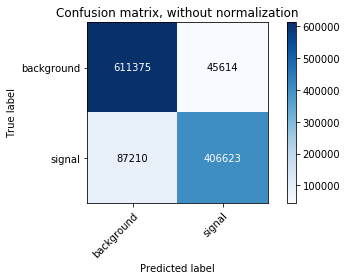

In [20]:
plot_confusion_matrix(Y_test_clean, Y_pred, ['background','signal'], normalize=False)

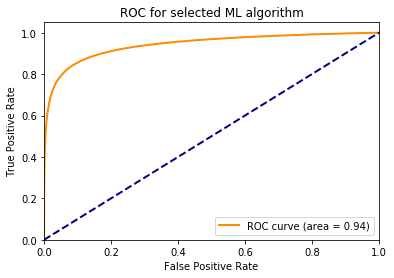

In [21]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y_test_clean,Y_pred_proba[:,1], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for selected ML algorithm')
plt.legend(loc="lower right")
plt.show()

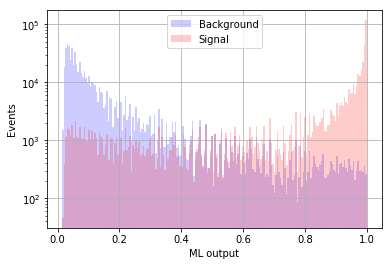

In [22]:
n, bins, patches = plt.hist(Y_pred_proba[:,1][Y_test==0], 200, normed=0, facecolor='blue', alpha=0.2,label="Background")
n, bins, patches = plt.hist(Y_pred_proba[:,1][Y_test==1], 200, normed=0, facecolor='red', alpha=0.2, label="Signal")

plt.xlabel('ML output')
plt.ylabel('Events')
plt.yscale('log')
#plt.title('XGBoost output, HiggsML dataset, validation data')
plt.grid(True)
plt.legend()
plt.show()